#Тематическая модель на данных Last.fm

###Данные

Данные Last.fm брались <a href=http:/www.dtic.upf.edu/~ocelma/MusicRecommendationDataset/lastfm-360K.html> отсюда</a>. Они содержат плейлисты 360 тысяч пользователей с указанием сколько раз каждый юзер слушал музыканта. Эти плейлисты рассматривались как документы в тематической модели, и выделенные темы образовывали различные музыкальные жанры (названия которых я оставлю подобрать читателю).

###Процесс

Подключаем все необходимые библиотеки.

In [1]:
from lastfm_util import *
import matplotlib.pyplot as plt

import artm.artm_model
from artm.artm_model import *

%matplotlib inline

plays_file = 'usersha1-artmbid-artname-plays.tsv' #Название файла с данными

Теперь надо распарсить коллекцию и подать ее библиотеке. Я использовал свой парсер и создавал вручную батчи в нужном формате.

In [2]:
batch_path = create_batches(users_to_handle = 5000, users_in_batch = 1000) 
#Мы обрабатываем только первые 5 тысяч записей и строим батчи по 1000 штук юзеров в каждом

Следующий шаг - настоить и запустить bigartm.

Создаем названия главных и фоновых тем, потом настраиваем регуляризаторы и счетчики.

In [3]:
all_topics, objective_topics, background_topics = create_topic_names(200, 5)

model = ArtmModel(topic_names=all_topics)
model.num_processors = 4

#Счетчики
model.scores.add(SparsityPhiScore(name='ObjectiveSparsityPhiScore', topic_names=objective_topics))
model.scores.add(SparsityThetaScore(name='ObjectiveSparsityThetaScore', topic_names=objective_topics))
model.scores.add(PerplexityScore(name='PerplexityScore'))
model.scores.add(TopTokensScore(name='TopTokensScore', num_tokens=5))
model.scores.add(TopTokensScore(name='TopTokensScoreExtended', num_tokens=20))

#Регуляризаторы
model.regularizers.add(SmoothSparsePhiRegularizer(name='ObjectiveSparsePhi',
                                                  topic_names=objective_topics, tau=-0.1))
model.regularizers.add(SmoothSparseThetaRegularizer(name='ObjectiveSparseTheta',
                                                    topic_names=objective_topics, tau=-2.0))
model.regularizers.add(SmoothSparsePhiRegularizer(name='BackgroundSparsePhi',
                                                  topic_names=background_topics, tau=0.1))
model.regularizers.add(SmoothSparseThetaRegularizer(name='BackgroundSparseTheta',
                                                    topic_names=background_topics, tau=2.0))
model.regularizers.add(DecorrelatorPhiRegularizer(name='DecorrelatorPhi',
                                                  topic_names=objective_topics, tau=100000.0))

model.initialize(data_path=batch_path)

Запускаем!

In [4]:
model.fit_offline(data_path=batch_path, num_collection_passes=15)

Теперь уже можно порисовать графики и вывести жанры. 

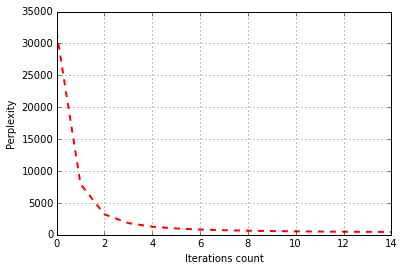

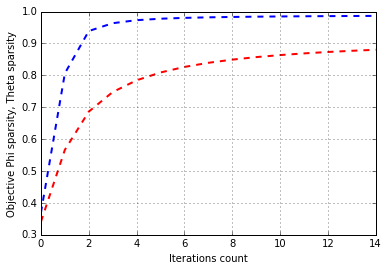

In [5]:
plt.plot(range(model.num_phi_updates), model.scores_info['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

plt.plot(range(model.num_phi_updates), model.scores_info['ObjectiveSparsityPhiScore'].value, 'b--',
         range(model.num_phi_updates), model.scores_info['ObjectiveSparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Objective Phi sparsity, Theta sparsity')
plt.grid(True)
plt.show()

In [6]:
print_genres(model, objective_topics, background_topics)

Genres
objective topic 0:  [u'gods of blitz', u'la vela puerca', u'laura marling', u'bromheads jacket', u'fionn regan']
objective topic 1:  [u'dropkick murphys', u'flogging molly', u'the real mckenzies', u'street dogs', u'leona lewis']
objective topic 2:  [u'linkin park', u'evanescence', u'fort minor', u'ko\u042fn', u'bruce faulconer']
objective topic 3:  [u'ac/dc', u'ramones', u'led zeppelin', u'sex pistols', u'the rolling stones']
objective topic 4:  [u'nelly furtado', u'black eyed peas', u'aaliyah', u'sean paul', u'rihanna']
objective topic 5:  [u'die \xc4rzte', u'die toten hosen', u'farin urlaub', u'annihilator', u'freak kitchen']
objective topic 6:  [u'michael bubl\xe9', u'guano apes', u'live', u'rage against the machine', u'tristania']
objective topic 7:  [u'hellogoodbye', u'project 86', u'alter bridge', u'chevelle', u'12 stones']
objective topic 8:  [u'r.e.m.', u'billie the vision & the dancers', u'mando diao', u'camel', u'the disciplines']
objective topic 9:  [u'bad religion', 

Дальше мы можем по этой тематической модели искать похожих артистов и давать рекомендации пользователям.

Например, найдем похожих артистов для Metallica, Green day и Арии. 

In [7]:
print "Mettalica"
for musician in find_similar_musicians(model, "metallica", 5, objective_topics):
    print musician[0], musician[1]
print "Green day"
for musician in find_similar_musicians(model, "green day", 5, objective_topics):
    print musician[0], musician[1]
print "Ария"
for musician in find_similar_musicians(model, "ария", 5, objective_topics):
    print musician[0], musician[1]

Mettalica
0.0208105176986 iron maiden
0.0134819296878 pink floyd
0.0123659968761 red hot chili peppers
0.0102545423153 megadeth
0.00803689530376 system of a down
Green day
0.0135458926306 koЯn
0.00496888888417 marilyn manson
0.0049557271206 linkin park
0.00482540278483 slipknot
0.00346017851831 ozzy osbourne
Ария


lastfm_util.py:173: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if musician in topic_musicians:
